### Acquire Data

In [1]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import pandas as pd
import json
import requests
import os
import warnings
import time
from langdetect import detect
from dotenv import load_dotenv
load_dotenv()

access_token = os.environ.get("access_token")

workshop_channel_id = os.environ.get("workshop_channel_id")
vc_channel_id = os.environ.get("vc_channel_id")
weebchat_channel_id = os.environ.get("weebchat_channel_id")
lol_channel_id = os.environ.get("lol_channel_id")
valorant_channel_id = os.environ.get("valorant_channel_id")

In [2]:
def jsonToDataframe(messages_json, channel_name):
    timestamps = []
    username = []
    content = []
    message_id = []
    for message in messages_json:
        timestamps.append(message['timestamp'])
        username.append(message['author']['username'])
        content.append(message['content'])
        message_id.append(message['id'])

    list_of_tuples = list(zip(username, timestamps, content, message_id)) 

    df = pd.DataFrame(list_of_tuples,
                      columns = ['username', 'timestamps', 'content', 'message_id']) 
    df['channel'] = channel_name
    
    return df

def getChannelMessages(access_token, channel_id, channel_name):
    api_url = "https://discord.com/api/channels/" + channel_id + "/messages?limit=100"
    api_call_headers = {'Authorization': 'Bot ' + access_token}
    api_call_response = requests.get(api_url, headers=api_call_headers, verify=False)

    messages_raw = api_call_response.text
    messages_json_new = json.loads(messages_raw)

    messages_json = messages_json_new.copy() # create deep copy of list 
    
    print(f"Working on channel: #%s" %channel_name)
    
    while len(messages_json_new) > 0: 
        messages_json.extend(messages_json_new)
        starting_id = messages_json[-1]['id']
        
        time.sleep(1)
        
        api_url = "https://discord.com/api/channels/" + channel_id + "/messages?limit=100&before=" + starting_id
        api_call_response = requests.get(api_url, headers=api_call_headers, verify=False)
        
        messages_raw = api_call_response.text
        messages_json_new = json.loads(messages_raw)
        
    return messages_json

In [3]:
# Messages Pull and JSON Conversion
warnings.filterwarnings("ignore")

#workshop
workshop_json = getChannelMessages(access_token, workshop_channel_id, 'workshop')
workshop_df = jsonToDataframe(workshop_json, 'workshop')
print("Done Retrieving Messages from #workshop") 

#vc-discussion
vc_json = getChannelMessages(access_token, vc_channel_id, 'discussion')
vc_df = jsonToDataframe(vc_json, 'vc-discussion')
print("Done Retrieving Messages from #vc-discussion") 

#weebchat
weebchat_json = getChannelMessages(access_token, weebchat_channel_id, 'weebchat')
weebchat_df = jsonToDataframe(weebchat_json, 'weebchat')
print("Done Retrieving Messages from #weebchat") 

#lol
lol_json = getChannelMessages(access_token, lol_channel_id, 'lol')
lol_df = jsonToDataframe(lol_json, 'lol')
print("Done Retrieving Messages from #lol") 

#valorant
valorant_json = getChannelMessages(access_token, valorant_channel_id, 'valorant' )
valorant_df = jsonToDataframe(valorant_json, 'valorant')
print("Done Retrieving Messages from #valorant")

Working on channel: #workshop
Done Retrieving Messages from #workshop
Working on channel: #discussion
Done Retrieving Messages from #vc-discussion
Working on channel: #weebchat
Done Retrieving Messages from #weebchat
Working on channel: #lol
Done Retrieving Messages from #lol
Working on channel: #valorant
Done Retrieving Messages from #valorant


### Clean Data

In [77]:
# Combine all dataframes, lose message ids
df = pd.concat([workshop_df, vc_df, weebchat_df, lol_df, valorant_df])
df = df.drop('message_id', axis = 1)
len(df)

5910

In [78]:
# Remove Bot Messages
bots = ["gambling bot", "MEE6", "Simple Poll", "Sidekick", 
        'Groovy', 'Groovy 2', 'Groovy 3', 'Tourney Bot', 
        'Rythm', 'TriviaBot', 'K-pop Music Quiz', 
        'Birthday Bot', 'Dyno', 'sesh', 'Pepper_Potts']
df = df[~df['username'].isin(bots)]
print(len(df))

5742


In [79]:
# Remove gifs, tags, weird emotes, and outside links
df['content'] = df['content'].str.replace(r'(<@.*>)', '') # removing tags
df['content'] = df['content'].str.replace(r'(https://\S*)', '') # removing links & gifs
df['content'] = df['content'].str.replace(r'(<.*>)', '') # removing weird reacts
df['content'] = df['content'].str.replace(r'(🥲*)', '') # removing encoding issues

In [81]:
# Remove BLANK content
df = df[df['content'] != ""]

In [106]:
df.username.unique()

array(['kumomi18', 'aaliyah', 'Pikachi', '626', 'Naughty Roti', 'nuna_d',
       'Rohnji', 'grogu', 'IRON', 'mattyv43', 'Prime', 'Yang', 'Gremlin',
       'suchadad', 'Floseidon', 'Tenecchi', 'Siddartha', 'fancypants',
       'Chucher', 'Raederle', 'DrewTheDon', 'CrabRaveDad', 'ellie',
       'DownToPho', 'Bennay', 'jacksmores', 'Kaivitz', 'rina', 'archerja',
       'chimkin nugget', 'NatRae', 'Pnoyy-', '.ryan', 'peepeepoopoo',
       'Den~', 'ericle0n', 'neely', 'lael54', 'Zo', 'Maalikin',
       'NotoriousCAT', 'Alfredo', 'TurkeyManLaFlare', 'ricki', 'cass',
       'alpha', 'MethodAct', 'thegreatgabola', 'star.duhst', 'LoreVerne',
       'danny', 'Zandophen', 'Fadesimop', 'kyujeans', 'Ryde', 'Raydjinn',
       'asheu', 'tht0033', 'Eric', 'Autobot42', 'YOINGEPIC', 'Adrian G',
       'Mags Magpie', 'jess✨', 'Grucknaar', 'D3Saim', 'kaiga'],
      dtype=object)

### Word Cloud based on Your Frequency

https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb

In [94]:
# create a list of candidates
usernames = df.username.unique()
#create a list of responses for each candidate using a list comprehension
corpus = [' '.join(df[(df.username==user)].content.tolist()) for user in usernames]

# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

#instantiate a CountVectorizer object
# utilize the new STOP_WORDS list
cv=CountVectorizer( stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 3))

# fit transform our text and create a dataframe with the result
X = cv.fit_transform(corpus)
X = X.toarray()

bow=pd.DataFrame(X, columns = cv.get_feature_names())
bow.index=usernames

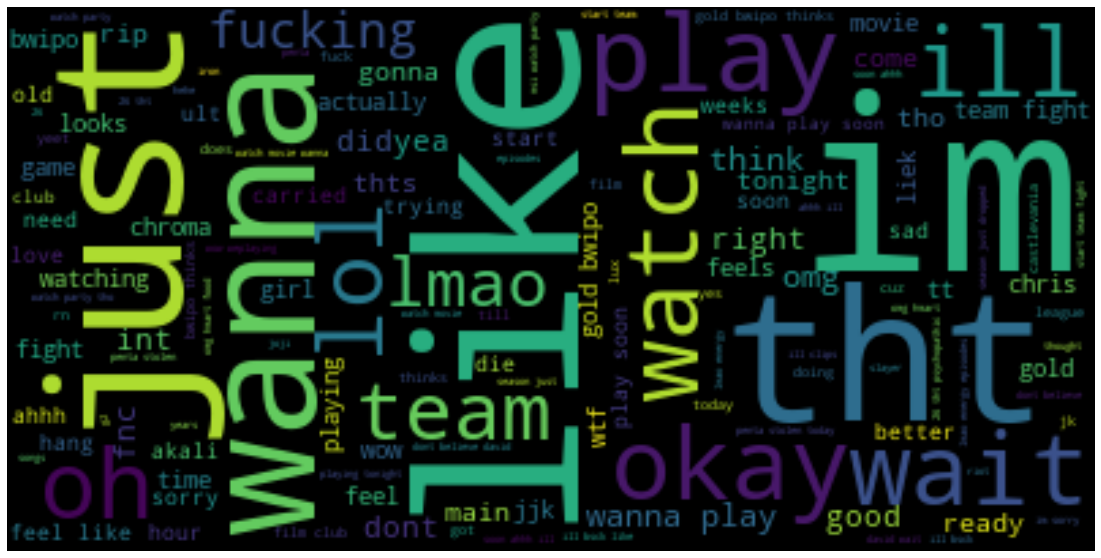

In [160]:
# create a pandas Series of the top 4000 most frequent words
text=bow.loc['Pikachi'].sort_values(ascending=False)[:4000]

# create a dictionary Note: you could pass the pandas Series directoy into the wordcloud object
text2_dict=bow.loc['Pikachi'].sort_values(ascending=False).to_dict()

# create the WordCloud object
wordcloud = WordCloud(min_word_length =3,
                      background_color='black')

# generate the word cloud
wordcloud.generate_from_frequencies(text2_dict)

#plot
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Wordcloud based on Word Most Unique to You


In [102]:
from tqdm import tqdm #used for progress bar
import math

#build an empty dataframe
t_bow_df=pd.DataFrame()

# By candidate, divide the number of times a word is said, 
# by the total number of times they've said all the words that they have said (frequency)
bow_transformed = bow.apply(lambda x: (x+1)/ (bow.loc[x.name].sum()+1), axis=1) 

for candidate in tqdm(usernames):
    feat_s = bow[bow.index != candidate].sum()+1 #sum all the times each word was said excluding the candidate
    feat_s_all = np.sum(bow[bow.index != candidate].sum()) # all the total words that were said, excluding the candidate
    tot = feat_s / feat_s_all #find the frequency of words said among other candidates
    row = bow_transformed.loc[candidate] / tot #divide the candidate's array of frequency of words by all other candidates' frequency
    row = pd.DataFrame(row).T #create a df, and transform
    results = row.apply(lambda x: math.log(x,2)) #take the log of each frequency
    
    t_bow_df = pd.concat([t_bow_df, pd.DataFrame([results], index=[candidate])]) #append to df


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:15<00:00,  1.13s/it]


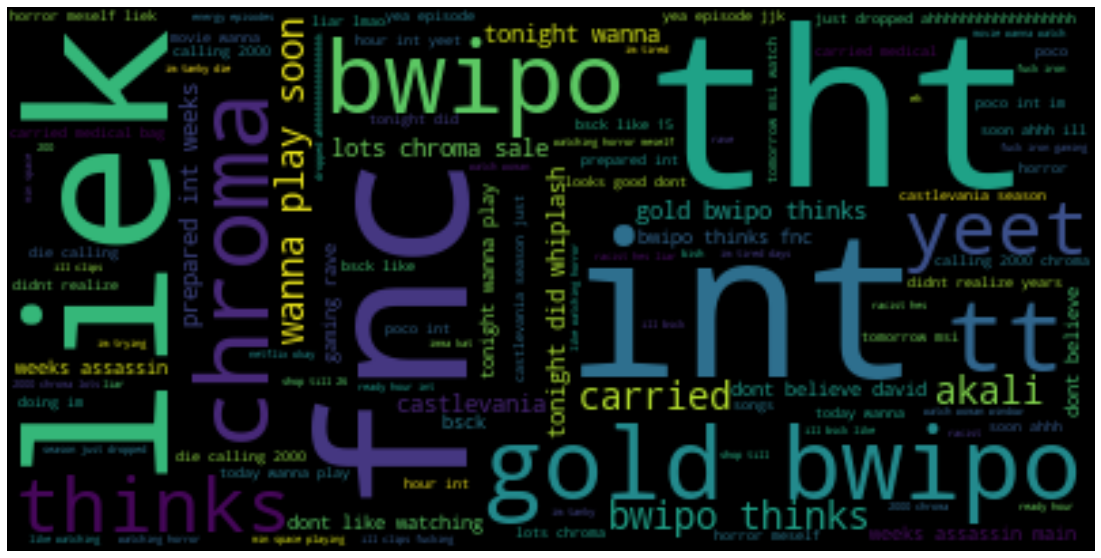

In [161]:
# create a pandas Series of the top 4000 most frequent words
text=t_bow_df.loc['Pikachi'].sort_values(ascending=False)[:4000]

# create a dictionary Note: you could pass the pandas Series directoy into the wordcloud object
text2_dict=t_bow_df.loc['Pikachi'].sort_values(ascending=False).to_dict()

# create the WordCloud object
wordcloud = WordCloud(min_word_length =3,
                      background_color='black')

# generate the word cloud
wordcloud.generate_from_frequencies(text2_dict)

#plot
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()